In [126]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split


In [127]:
# read data
df_incidents = pd.read_csv('../datasets_clean/incidents_clean.csv', index_col=0)


In [128]:
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2015.0
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,1.0,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured,2016.0
5,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2014.0
6,2018-01-25,Louisiana,Zachary,18733 Samuels Rd,30.6069,-91.2270,6.0,26.0,0.0,0.0,5.0,5.0,0.0,2,1,2.0,0.0,5.0,Shot - Wounded/Injured,2018.0


In [129]:
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174421 entries, 0 to 239311
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       174421 non-null  object 
 1   state                      174421 non-null  object 
 2   city_or_county             174421 non-null  object 
 3   address                    162143 non-null  object 
 4   latitude                   174421 non-null  float64
 5   longitude                  174421 non-null  float64
 6   congressional_district     164507 non-null  float64
 7   avg_age_participants       174421 non-null  float64
 8   n_participants_child       174421 non-null  float64
 9   n_participants_teen        174421 non-null  float64
 10  n_participants_adult       174421 non-null  float64
 11  n_males                    174421 non-null  float64
 12  n_females                  174421 non-null  float64
 13  n_killed                   17

In [130]:
df_incidents['isKilled'] = df_incidents['n_killed'] > 0

<Axes: title={'center': 'Percentage of incidents with killed people'}, ylabel='isKilled'>

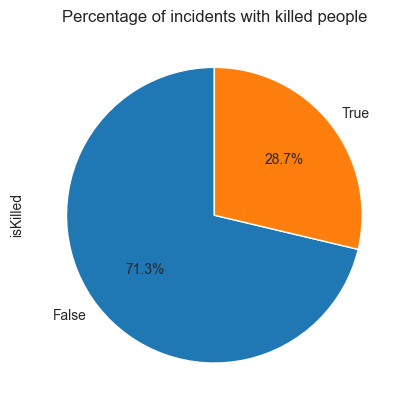

In [131]:
#pie chart
df_incidents['isKilled'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title = 'Percentage of incidents with killed people')

## Extracting features

In [132]:
cols2drop =['date', 'year', 'state', 'city_or_county', 'n_killed', 'incident_characteristics1', 'congressional_district', 'address']
df_incidents = df_incidents.drop(cols2drop, axis=1)

In [133]:
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174421 entries, 0 to 239311
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   latitude              174421 non-null  float64
 1   longitude             174421 non-null  float64
 2   avg_age_participants  174421 non-null  float64
 3   n_participants_child  174421 non-null  float64
 4   n_participants_teen   174421 non-null  float64
 5   n_participants_adult  174421 non-null  float64
 6   n_males               174421 non-null  float64
 7   n_females             174421 non-null  float64
 8   n_injured             174421 non-null  int64  
 9   n_arrested            174421 non-null  float64
 10  n_unharmed            174421 non-null  float64
 11  n_participants        174421 non-null  float64
 12  isKilled              174421 non-null  bool   
dtypes: bool(1), float64(11), int64(1)
memory usage: 17.5 MB


## K-nearest neighbors

In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We split the data first into development and test set, then we split again the development set into training and validation set. We use the training set to train the model and the validation set to evaluate the model. We use the test set to evaluate the model on unseen data.
We used a ratio of 70% development set and 30% test set.
Then we used a ratio of 75% training set and 25% validation set.

In [135]:
# split data
X = df_incidents.drop('isKilled', axis=1)
y = df_incidents['isKilled']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)
print(' # X_train: ', X_train.shape[0])
print(' # X_val : ', X_val.shape[0])
print(' # X_test : ', X_test.shape[0])
print("% killed in train set: ", y_train.sum()/y_train.shape[0])
print("% killed in val set: ", y_val.sum()/y_val.shape[0])
print("% killed in test set: ", y_test.sum()/y_test.shape[0])


 # X_train:  111192
 # X_val :  37065
 # X_test :  26164
% killed in train set:  0.28671127419238795
% killed in val set:  0.28700930797248075
% killed in test set:  0.28898486469958723


In [136]:
# standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [137]:
X_train_balanced = np.concatenate((X_train[y_train==1], X_train[y_train==0][:X_train[y_train==1].shape[0]]))
y_train_balanced = np.concatenate((y_train[y_train==1], y_train[y_train==0][:y_train[y_train==1].shape[0]]))
print(' # X_train_balanced: ', X_train_balanced.shape[0])
print(' # y_train_balanced: ', y_train_balanced.shape[0])
print("% killed in train set: ", y_train_balanced.sum()/y_train_balanced.shape[0])

 # X_train_balanced:  63760
 # y_train_balanced:  63760
% killed in train set:  0.5


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_4108\1769743730.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_balanced = np.concatenate((y_train[y_train==1], y_train[y_train==0][:y_train[y_train==1].shape[0]]))


In [138]:
# train model
accuracy_scores = []
for i in tqdm(range(1, 10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy_scores.append(accuracy_score(y_val, y_pred))

100%|██████████| 9/9 [03:55<00:00, 26.20s/it]


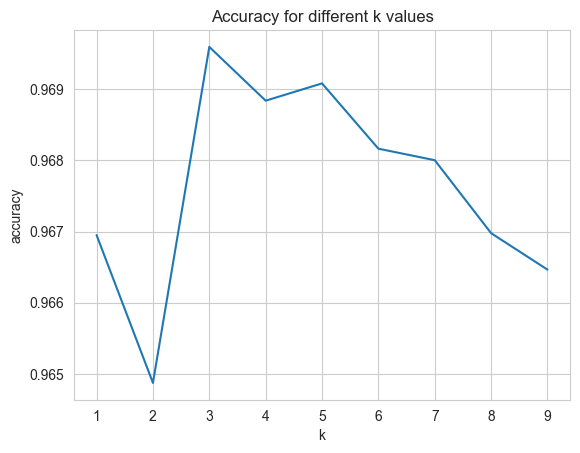

In [139]:
plt.plot(range(1, 10), accuracy_scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Accuracy for different k values')
plt.show()

In [140]:
# train again with best k on whole dev set
X_dev = scaler.fit_transform(X_dev)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_dev, y_dev)
print('ended fit')
y_pred = knn.predict(X_test)
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

ended fit
Accuracy on test set:  0.9711053355756001
Confusion matrix: 
 [[18240   363]
 [  393  7168]]
Classification report: 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98     18603
        True       0.95      0.95      0.95      7561

    accuracy                           0.97     26164
   macro avg       0.97      0.96      0.96     26164
weighted avg       0.97      0.97      0.97     26164



## Logistic regression

In [141]:
from sklearn.linear_model import LogisticRegression


In [142]:
# train model
logreg = LogisticRegression('none')
logreg_model = logreg.fit(X_train_balanced, y_train_balanced)
y_pred = logreg.predict(X_val)
y_pred_train = logreg.predict(X_train_balanced)
print('Accuracy on training set: ', accuracy_score(y_train_balanced, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train_balanced, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_val, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_val, y_pred))
print('Classification report: \n', classification_report(y_val, y_pred))

Accuracy on training set:  0.9805207026348808
confusion_matrix on training set: 
 [[31082   798]
 [  444 31436]]
Accuracy on validation set:  0.9774180493727236
Confusion matrix: 
 [[25756   671]
 [  166 10472]]
Classification report: 
               precision    recall  f1-score   support

       False       0.99      0.97      0.98     26427
        True       0.94      0.98      0.96     10638

    accuracy                           0.98     37065
   macro avg       0.97      0.98      0.97     37065
weighted avg       0.98      0.98      0.98     37065



C:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


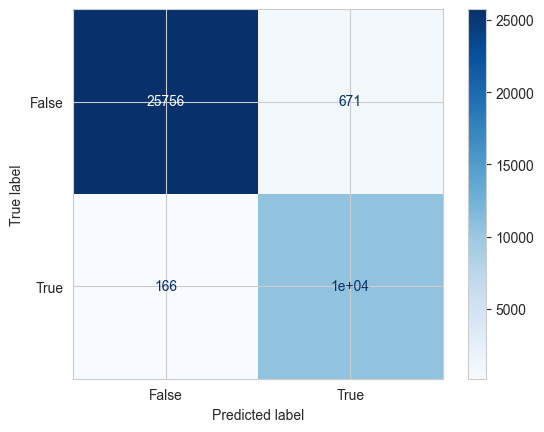

In [143]:
# plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

In [144]:
# print weights of model
print('Feature weights: \n', logreg_model.coef_)

Feature weights: 
 [[-0.18385853 -0.10369904  0.1177874   0.16865053  0.51424418  1.28627031
   0.81813529  0.2477195  -5.90679017 -6.66275363 -6.9126678   7.29308995]]


We noticed that the last four weights are very big.
Those weights correspond to the features 'n_injured', 'n_unharmed', 'n_arrested' and 'n_participants'.
The model is learning to predict the target variable subtracting the first three feature from 'n_participants'.
We can argue that if the number of killed is unknown, the number of injured,  is also unknown.


## Logistic regression with less features

In [145]:
more_cols2drop=['n_injured', 'n_unharmed', 'n_arrested']

In [146]:
df_incidents = df_incidents.drop(more_cols2drop, axis=1)


In [147]:
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174421 entries, 0 to 239311
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   latitude              174421 non-null  float64
 1   longitude             174421 non-null  float64
 2   avg_age_participants  174421 non-null  float64
 3   n_participants_child  174421 non-null  float64
 4   n_participants_teen   174421 non-null  float64
 5   n_participants_adult  174421 non-null  float64
 6   n_males               174421 non-null  float64
 7   n_females             174421 non-null  float64
 8   n_participants        174421 non-null  float64
 9   isKilled              174421 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 13.5 MB


In [148]:
X2=df_incidents.drop('isKilled', axis=1)
y2=df_incidents['isKilled']
X_dev2, X_test2, y_dev2, y_test2 = train_test_split(X2, y2, test_size=0.15, random_state=42)

In [149]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_dev2, y_dev2, test_size=0.25, random_state=42)
print(' # X_train2: ', X_train2.shape[0])
print(' # X_val2 : ', X_val2.shape[0])
print(' # X_test2 : ', X_test2.shape[0])
print("% killed in train set: ", y_train2.sum()/y_train2.shape[0])
print("% killed in val set: ", y_val2.sum()/y_val2.shape[0])
print("% killed in test set: ", y_test2.sum()/y_test2.shape[0])


 # X_train2:  111192
 # X_val2 :  37065
 # X_test2 :  26164
% killed in train set:  0.28671127419238795
% killed in val set:  0.28700930797248075
% killed in test set:  0.28898486469958723


In [150]:
# standardize data
X_train2 = scaler.fit_transform(X_train2)
X_val2 = scaler.transform(X_val2)
X_test2 = scaler.transform(X_test2)


In [151]:
X_train2.shape

(111192, 9)

In [152]:
#logistic regression
logreg2 = LogisticRegression('none')
logreg_model2 = logreg2.fit(X_train2, y_train2)
y_pred2 = logreg2.predict(X_val2)
y_pred_train2 = logreg2.predict(X_train2)
print('Accuracy on validation set: ', accuracy_score(y_val2, y_pred2))
print('Confusion matrix: \n', confusion_matrix(y_val2, y_pred2))
print('Classification report: \n', classification_report(y_val2, y_pred2))

Accuracy on validation set:  0.7113449345743963
Confusion matrix: 
 [[25890   537]
 [10162   476]]
Classification report: 
               precision    recall  f1-score   support

       False       0.72      0.98      0.83     26427
        True       0.47      0.04      0.08     10638

    accuracy                           0.71     37065
   macro avg       0.59      0.51      0.46     37065
weighted avg       0.65      0.71      0.61     37065



C:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


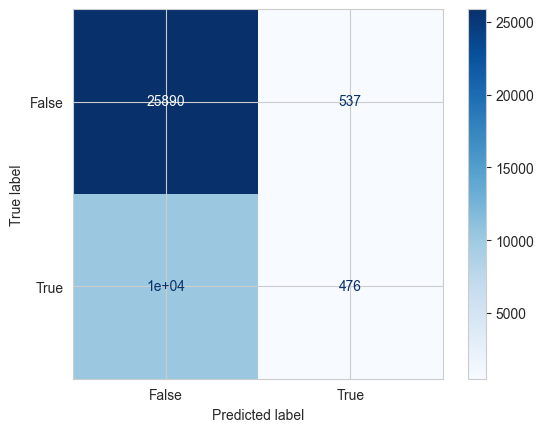

In [166]:
# plot confusion matrix
plot_confusion_matrix(logreg_model2, X_val2, y_val2, cmap=plt.cm.Blues)

In [153]:
# knn
accuracy_scores2 = []
for i in tqdm(range(1, 10)):
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X_train2, y_train2)
    y_pred2 = knn2.predict(X_val2)
    accuracy_scores2.append(accuracy_score(y_val2, y_pred2))

100%|██████████| 9/9 [02:36<00:00, 17.43s/it]


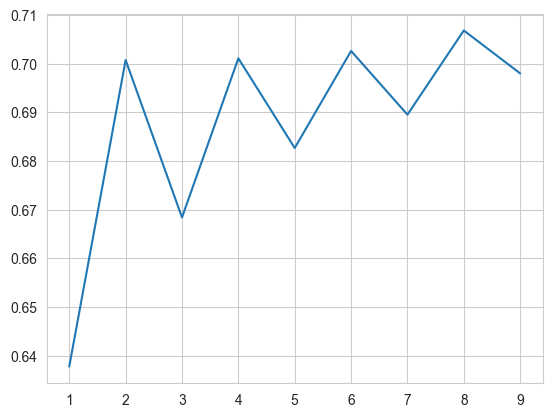

In [154]:
plt.plot(range(1, 10), accuracy_scores2)

In [155]:
# train again with best k on whole dev set
X_dev2 = scaler.fit_transform(X_dev2)
knn2 = KNeighborsClassifier(n_neighbors=8)
knn2.fit(X_dev2, y_dev2)
y_pred2 = knn2.predict(X_test2)
print('Accuracy on test set: ', accuracy_score(y_test2, y_pred2))
print('Confusion matrix: \n', confusion_matrix(y_test2, y_pred2))
print('Classification report: \n', classification_report(y_test2, y_pred2))

Accuracy on test set:  0.7078810579422107
Confusion matrix: 
 [[17109  1494]
 [ 6149  1412]]
Classification report: 
               precision    recall  f1-score   support

       False       0.74      0.92      0.82     18603
        True       0.49      0.19      0.27      7561

    accuracy                           0.71     26164
   macro avg       0.61      0.55      0.54     26164
weighted avg       0.66      0.71      0.66     26164



## df with prepared features

In [156]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)

In [157]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 2015-05-02 to 2015-05-05
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state                      161550 non-null  object 
 1   city_or_county             161550 non-null  object 
 2   address                    149848 non-null  object 
 3   latitude                   161550 non-null  float64
 4   longitude                  161550 non-null  float64
 5   congressional_district     161550 non-null  float64
 6   avg_age_participants       161550 non-null  float64
 7   n_killed                   161550 non-null  int64  
 8   incident_characteristics1  161550 non-null  object 
 9   year                       161550 non-null  float64
 10  age_group                  161550 non-null  object 
 11  povertyPercentage          161550 non-null  float64
 12  population                 161550 non-null  int64  
 13  party                

In [158]:
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [159]:
cols2drop =['year', 'state', 'city_or_county', 'n_killed', 'incident_characteristics1', 'congressional_district', 'address', 'year_month', 'age_group', 'party', 'candidatevotes', 'severity_cat', 'dfm_district_killed', 'killed_by_district', 'severity' ]
df_incidents_prepared = df_incidents_prepared.drop(cols2drop, axis=1)

In [160]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 2015-05-02 to 2015-05-05
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   161550 non-null  float64
 1   longitude                  161550 non-null  float64
 2   avg_age_participants       161550 non-null  float64
 3   povertyPercentage          161550 non-null  float64
 4   population                 161550 non-null  int64  
 5   severity_minor             161550 non-null  float64
 6   injured_by_district        161550 non-null  float64
 7   arrested_ratio             161550 non-null  float64
 8   unharmed_ratio             161550 non-null  float64
 9   right_or_left              161550 non-null  float64
 10  dfm_district_injured       161550 non-null  float64
 11  dfm_district_participants  161550 non-null  float64
 12  dfm_district_child         161550 non-null  float64
 13  dfm_district_teen    

In [161]:
X3=df_incidents_prepared.drop('isKilled', axis=1)
y3=df_incidents_prepared['isKilled']
X_dev3, X_test3, y_dev3, y_test3 = train_test_split(X3, y3, test_size=0.15, random_state=42)

In [162]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_dev3, y_dev3, test_size=0.25, random_state=42)
print(' # X_train3: ', X_train3.shape[0])
print(' # X_val3 : ', X_val3.shape[0])
print(' # X_test3 : ', X_test3.shape[0])
print("% killed in train set: ", y_train3.sum()/y_train3.shape[0])
print("% killed in val set: ", y_val3.sum()/y_val3.shape[0])
print("% killed in test set: ", y_test3.sum()/y_test3.shape[0])


 # X_train3:  102987
 # X_val3 :  34330
 # X_test3 :  24233
% killed in train set:  0.2818705273481119
% killed in val set:  0.28191086513253716
% killed in test set:  0.2769776750711839


In [163]:
# standardize data
X_train3 = scaler.fit_transform(X_train3)
X_val3 = scaler.transform(X_val3)
X_test3 = scaler.transform(X_test3)
X_dev3 = scaler.transform(X_dev3)

In [164]:
#logistic regression
logreg = LogisticRegression('l2')
logreg_model3 = logreg.fit(X_train3, y_train3)
y_pred3 = logreg.predict(X_val3)
y_pred_train3 = logreg.predict(X_train3)
print('Accuracy on training set: ', accuracy_score(y_train3, y_pred_train3))
print('confusion_matrix on training set: \n', confusion_matrix(y_train3, y_pred_train3))
print('Accuracy on validation set: ', accuracy_score(y_val3, y_pred3))
print('Confusion matrix: \n', confusion_matrix(y_val3, y_pred3))
print('Classification report: \n', classification_report(y_val3, y_pred3))

Accuracy on training set:  0.9257964597473467
confusion_matrix on training set: 
 [[71204  2754]
 [ 4888 24141]]
Accuracy on validation set:  0.9282551704048937
Confusion matrix: 
 [[23774   878]
 [ 1585  8093]]
Classification report: 
               precision    recall  f1-score   support

       False       0.94      0.96      0.95     24652
        True       0.90      0.84      0.87      9678

    accuracy                           0.93     34330
   macro avg       0.92      0.90      0.91     34330
weighted avg       0.93      0.93      0.93     34330



C:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


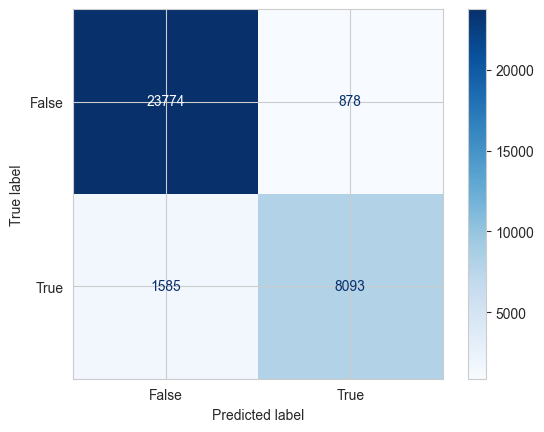

In [167]:
# plot confusion matrix
plot_confusion_matrix(logreg_model3, X_val3, y_val3, cmap=plt.cm.Blues)


In [165]:
# weights of model
for i in zip(df_incidents_prepared.columns, logreg_model3.coef_[0]):
    print(i)

('latitude', -0.46202007724890354)
('longitude', -0.3843752693380765)
('avg_age_participants', 0.2564377040933466)
('povertyPercentage', -0.009851598082919999)
('population', -0.10358036428262433)
('severity_minor', 0.1334638097274995)
('injured_by_district', 0.04962406852988731)
('arrested_ratio', -3.1853076926974992)
('unharmed_ratio', -3.182546267789495)
('right_or_left', 0.38320046946359615)
('dfm_district_injured', -3.284565086173139)
('dfm_district_participants', 2.6103575784797677)
('dfm_district_child', -0.20675243751900094)
('dfm_district_teen', -0.20537345355500752)
('dfm_district_females', -0.010692479634205516)
('voters_over_population', -0.07989185846781695)
